In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from PIL import Image
import tensorflow as tf
import shutil
import os
import math
import time

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Concatenate,BatchNormalization, Dropout,Conv2D,MaxPooling2D, Activation
from keras import regularizers
from keras.models import Model,Sequential
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import adadelta
from keras.utils import np_utils
# from spp.SpatialPyramidPooling import SpatialPyramidPooling
from keras.utils.np_utils import to_categorical


# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.visible_device_list = "0,1,2,3"
set_session(tf.Session(config=config))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Display Images

In [2]:
os.getcwd()

'/mnt/efs/carspotting/classifier'

In [3]:
path_to_images = '/mnt/efs/data/'

list_of_image_filepaths = glob.glob(path_to_images+'*/*/*/*/*/*.jpg')

In [4]:
len(list_of_image_filepaths)

46024

#### First 20 X5 Images

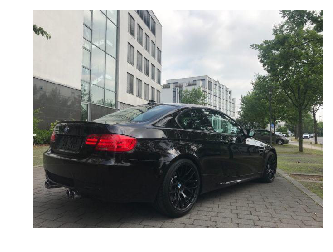

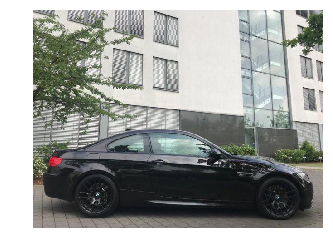

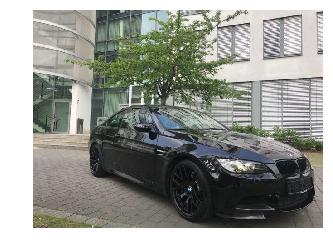

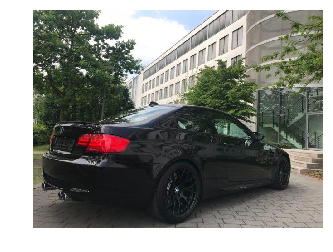

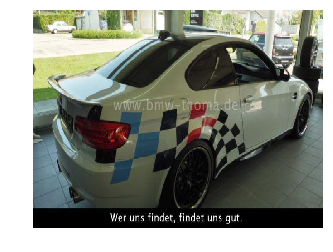

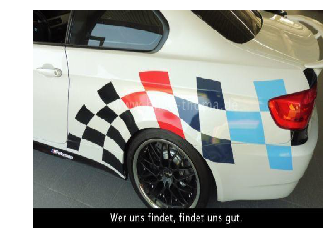

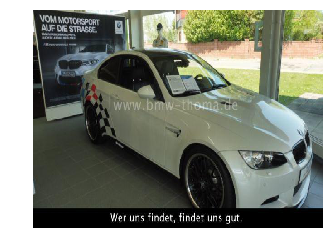

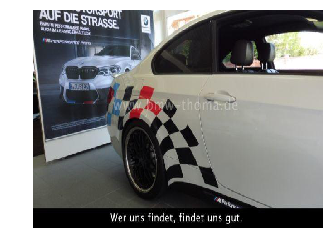

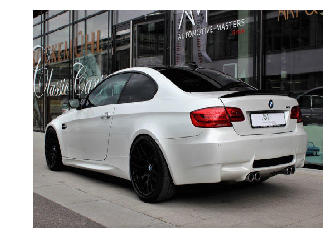

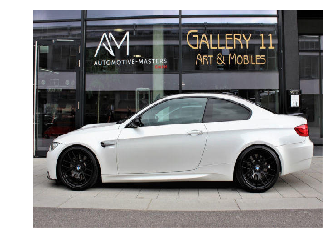

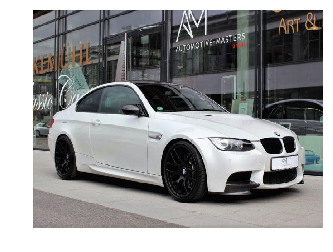

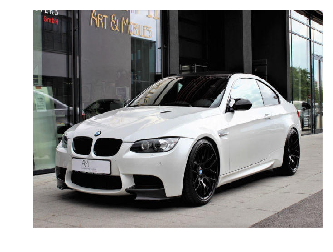

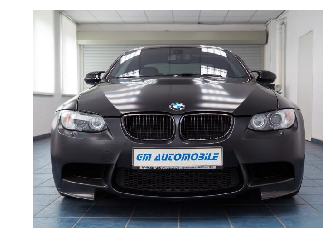

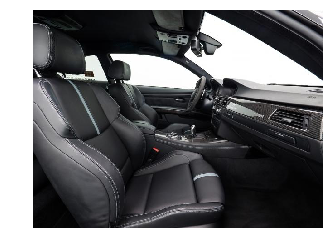

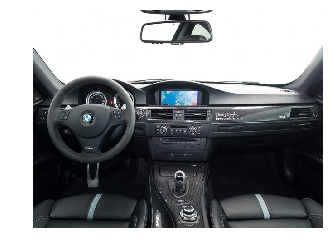

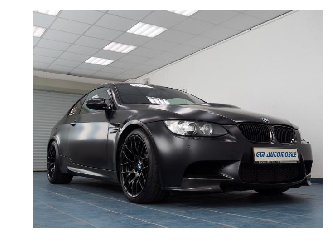

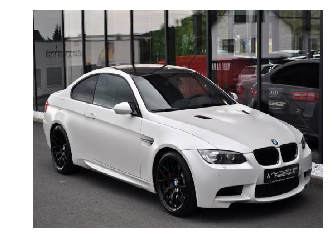

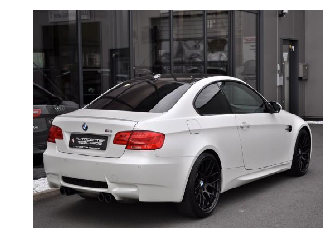

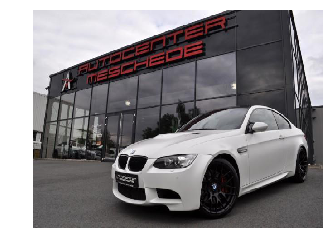

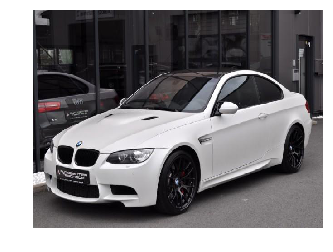

In [5]:
img_paths = list_of_image_filepaths[:20]
for img_path in img_paths:
    img=load_img(img_path,target_size=(480, 640))
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

### Monster Model

__Reload Data for ResNet__

In [6]:
"""
    input:
    filepath, percentiles
    
    output:
    X
    Y
"""

def Data_Loader(percentage_start,percentage_end,size,directory):
    X=[]
    Y=[]
    class_mapping = {}
    
    class_folders = glob.glob(directory+'/*/')
#     print(class_folders)
    
    label_counter = 0
    
    # through each class_folder
    for class_folder in class_folders:
        print(class_folder)
        
        # append class mapping
        class_mapping[str(label_counter)] = class_folder.split('/')[-1]
        
        # Load 1 series train data
        path_class_images = glob.glob(class_folder+'**/*.jpg', recursive=True)
        number_images = len(path_class_images)
        start_range = int(percentage_start*number_images)
        stop_range = int(percentage_end*number_images)
        print(start_range,stop_range)
        
        for path_class_image in path_class_images[start_range:stop_range]:
            #load img
            img = np.asarray(load_img(path_class_image,target_size=size))
            X.append(img)

            #append label
            Y.append(label_counter)
        label_counter+=1

    X = np.asarray(X)
    Y = np.asarray(Y)
    Y = to_categorical(Y)
    print(len(X),len(Y),X.shape,Y.shape)
    print(class_mapping)
    return X, Y,class_mapping

        

In [ ]:
# X, Y = Data_Loader(0,1,(224,224),list_of_image_filepaths)
train_perc=0.7
test_perc=0.85

X_train, Y_train, train_classes = Data_Loader(0,train_perc,(224,224),path_to_images)
X_test, Y_test, test_classes = Data_Loader(train_perc,test_perc,(224,224),path_to_images)
X_validation, Y_validation, validation_classes = Data_Loader(test_perc,1,(224,224),path_to_images)

/mnt/efs/data/model_M3/
0 1635
/mnt/efs/data/model_2er (alle)/
0 3158
/mnt/efs/data/model_6er (alle)/
0 786


__Reinitialize Data Generators__

In [ ]:
print('initializing train data gen')
train_datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=45.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    vertical_flip=True, # kippt an x achse
    horizontal_flip=True # kippt an y achse
    )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(X_train)

#initialize validation data generator (doesnt augment data)
validation_datagen = ImageDataGenerator()
validation_datagen.fit(X_validation)

__Visualize Training Data__

In [ ]:
X_batch, y_batch = train_datagen.flow(X_train, Y_train, batch_size=1).next()

In [ ]:
X_batch.shape

In [ ]:
X_batch = X_batch.reshape((224,224,3))

In [ ]:
y_batch[0]

In [ ]:
plt.figure()
plt.title(y_batch[0])
plt.axis('off')
plt.imshow(X_batch/255)

__Define Parameters__

In [4]:
batch_size = 64
epochs = 500
seed = 7
patience = 10
# class_weight = {0 : 1., 
#                 1: 1.}
steps_per_epoch = np.ceil(len(X_train) / batch_size)
#steps_per_epoch = np.ceil(len(X_train))

validation_steps = np.ceil(len(X_validation) / batch_size)
#validation_steps = np.ceil(len(X_validation))
early_stop_criteria = 'val_loss'
checkpoint_criteria = 'val_loss'
optimizer = 'adam'
loss = 'categorical_crossentropy'
number_classes = len(glob.glob(path_to_images+'/*/'))
input_shape= (224,224,3) # Standard for ResNet: (224,224,3)
verbose = 1
#general callbacks
stop = EarlyStopping(monitor=early_stop_criteria, patience=patience, verbose=1, mode='auto')
weights_path='checkpoint_weights/'
checkpoint = ModelCheckpoint(weights_path+'weights.{epoch:02d}-{val_loss:.2f}'+'.hdf5', monitor=checkpoint_criteria, save_best_only=True, mode='auto')
metrics=['accuracy']

NameError: name 'X_train' is not defined

In [ ]:
number_classes

__Transferlearning with ResNet50__

In [2]:
def load_model(input_shape, number_classes, ret_len=False):
    # pop the global average pooling layer
    model = ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=input_shape, pooling='max', classes=number_classes)
    model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') # cant include weights anymore? - should be possible
    n_bb = len(model.layers)-3
    x = model.layers[-3].output
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    pred = Dense(number_classes,activation='softmax')(x)
    model = Model(input=model.input, output=pred)
    n_top = len(model.layers) - n_bb
    print('model loaded')
    return (model, n_top) if ret_len else model

In [6]:
print('loading model')
input_shape=(224,224,3)
model,n_top = load_model(input_shape,27,ret_len=True)

loading model
model loaded


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [7]:
model.load_weights('checkpoint_weights_v1/weights.11-3.94.hdf5')

In [8]:
model.save('test_model.h5')

__Stagewise Training__

In [ ]:
def freeze_to(model, top_n):
    """Set the top n layers of model to trainable"""
    
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[0:(len(model.layers)-top_n)]:
        layer.trainable = False

In [ ]:
def unfreeze(model):
    """Set all layers of model to trainable"""
    
    for layer in model.layers:
        layer.trainable = True

In [ ]:
def fit_strategy(model, strategy, fitgen_kwargs, loss=None, optimizer=None, metrics=None, verbose=False):
    """Fit a training strategy for model.
    
    model: The model to be trained
    stragegy: List of dicts with keys n_top (top trainable layers) and optionally loss, optimizer and/or metrics
    fitgen_kwargs: dict of keyword arguments to be passed to model.fit_generator
    """
    
    training_histories=[]
    
    for i, strat in enumerate(strategy):
        for k in ['loss', 'optimizer', 'metrics']:
            if k not in strat.keys():
                strat[k] = eval(k)
        if strat['n_top']:
            freeze_to(model, strat['n_top'])
        else:
            unfreeze(model)
        if verbose:
            print('Fit model with strategy no. {}:\n n_top: {};loss: {};optimizer:\n {};metrics: {};\n fitgen_kwargs: {}'.format(i, strat['n_top'], strat['loss'], strat['optimizer'], strat['metrics'], fitgen_kwargs))
        
        #check whether this is the first training
        if i == 0:
            model.compile(loss=strat['loss'], optimizer=strat['optimizer'], metrics=strat['metrics'])
        else:
            print('loading best model')
            list_of_checkpoints = glob.glob(weights_path+'*') # * means all if need specific format then *.csv
            best_checkpoint = max(list_of_checkpoints, key=os.path.getctime)
            model.load_weights(best_checkpoint)
        training_history = model.fit_generator(**fitgen_kwargs)
        training_histories.append(training_history)
    list_of_checkpoints = glob.glob(weights_path+'*') # * means all if need specific format then *.csv
    best_checkpoint = max(list_of_checkpoints, key=os.path.getctime)
    model.load_weights(best_checkpoint)
    return model, training_histories
        
        # fits the model on batches with real-time data augmentation:


__Define Strategy__

In [ ]:
strategy = [{'n_top': n_top}, {'n_top': None}]
fitgen_kwargs = {
    'generator': train_datagen.flow(X_train, Y_train, batch_size=batch_size), 
    'steps_per_epoch': steps_per_epoch, 
    'epochs': epochs,
    'callbacks': [checkpoint,stop], 
    'validation_data': validation_datagen.flow(X_validation, Y_validation, batch_size=batch_size),
#     'class_weight': class_weight, 
    'verbose': verbose, 
    'validation_steps':validation_steps
}


__start training__

In [ ]:
model, histories = fit_strategy(model, strategy, fitgen_kwargs, loss=loss, optimizer=optimizer, metrics=metrics, verbose=True)

__Evaluate Training__

In [ ]:
# list all data in history
for hist in histories:
    print(hist.history.keys())

In [ ]:
for hist in histories:
    # summarize history for accuracy
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['acc','val_acc'], loc='lower right')
    plt.show()

    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss function')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend([ 'loss','val_loss'], loc='upper left')
    plt.show()

__Evaluate Model__

In [ ]:
score = model.evaluate(X_test, Y_test, batch_size=32)

In [ ]:
print(score)

## TODO: Result Visualization

In [ ]:
X_batch, y_batch = X_test[1],Y_test[1]

In [ ]:
X_batch = X_batch.reshape((224,224,3))

In [ ]:
plt.figure()
plt.title(y_batch[0])
plt.axis('off')
plt.imshow(X_batch/255)

In [ ]:
X_batch = X_batch.reshape((1,224,224,3))

In [ ]:
X_batch.shape

In [ ]:
score = model.evaluate(X_batch, y_batch, batch_size=1)

In [ ]:
y_batch.shape

In [ ]:
score